In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import pickle
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def generate_triplets(files, num_of_samples = 100):
    keys_count = {}
    samples = []
    duplicate_count = 0
    for i in tqdm(range(num_of_samples)):
        sample_idx = np.random.randint(0,len(files))
        class_name = files[sample_idx][1]
        for tries in range(10):
            anchor_positive_indices = np.random.choice(np.where(files[:,1]==class_name)[0],size=2,replace=False)
            negative_idx = np.random.choice(np.where(files[:,1]!=class_name)[0], size=1, replace=False)[0]
            triplet = (anchor_positive_indices[0],anchor_positive_indices[1],negative_idx)
            triplet_key = "-".join([str(anchor_positive_indices[0]),str(anchor_positive_indices[1]),str(negative_idx)])
            if triplet_key not in keys_count.keys():
                keys_count[triplet_key] = 0
                break
        keys_count[triplet_key] += 1
        if keys_count[triplet_key]>1:
            duplicate_count += 1
        samples.append(triplet)
    print("Duplicate Count:", duplicate_count)
    return samples

def fetch_files(directory, classes):
    files = [(os.path.join(directory,class_,file),class_) for class_ in classes for file in sorted(os.listdir(os.path.join(directory,class_)))]
    class_wise = {}
    for file in files:
        if file[1] not in class_wise.keys():
            class_wise[file[1]] = []
        class_wise[file[1]].append(file[0])
    return np.array(files), class_wise

def get_model(name):
    if name == "efficientnet-b0":
        model = torchvision.models.efficientnet.efficientnet_b0(pretrained=True)
    elif name == "efficientnet-b1":
        model = torchvision.models.efficientnet.efficientnet_b1(pretrained=True)
    elif name == "efficientnet-b2":
        model = torchvision.models.efficientnet.efficientnet_b2(pretrained=True)
    elif name == "efficientnet-b3":
        model = torchvision.models.efficientnet.efficientnet_b3(pretrained=True)
    elif name == "efficientnet-b4":
        model = torchvision.models.efficientnet.efficientnet_b4(pretrained=True)
    elif name == "efficientnet-b5":
        model = torchvision.models.efficientnet.efficientnet_b5(pretrained=True)
    elif name == "efficientnet-b6":
        model = torchvision.models.efficientnet.efficientnet_b6(pretrained=True)
    elif name == "efficientnet-b7":
        model = torchvision.models.efficientnet.efficientnet_b7(pretrained=True)
    elif name == "YOLOv10":
        model = torchvision.models.efficientnet.YOLOv10(pretrained=True)
    elif name == "resnet34":
        model = torchvision.models.efficientnet.resnet34(pretrained=True)
    elif name == "squeezenet1_1":
        model = torchvision.models.efficientnet.squeezenet1_1(pretrained=True)
    return model

class LeafyLoader(Dataset):
    def __init__(self, files, transforms):
        self.files = files
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        file = self.files[index]
        img = cv2.imread(file[0])
        label = file[1]
        return (
            np.transpose(self.transforms(image=img)["image"],(2,0,1)),
            label
        )
    
class LeafyTripletLoader(Dataset):
    def __init__(self, files, triplets, transforms):
        self.files = files
        self.triplets = triplets
        self.transforms = transforms
        
    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, index):
        triplet = self.triplets[index]
        anchor = cv2.imread(self.files[triplet[0]][0])
        positive = cv2.imread(self.files[triplet[1]][0])
        negative = cv2.imread(self.files[triplet[2]][0])
        return (
            np.transpose(self.transforms(image=anchor)["image"],(2,0,1)),
            np.transpose(self.transforms(image=positive)["image"],(2,0,1)),
            np.transpose(self.transforms(image=negative)["image"],(2,0,1))
        )
    

class LeafyModel(torch.nn.Module):
    def __init__(self, name="efficientnet-b0"):
        super(LeafyModel, self).__init__()
        model = get_model(name)
        self.embedder = torch.nn.Sequential(
            model,
            torch.nn.Linear(1000, 1024),
            torch.nn.PReLU(),
            torch.nn.Linear(1024, 512)
        )

    def forward(self, x):
        x = self.embedder(x)
        return x


In [3]:
base_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/"

classes = sorted(os.listdir(base_dir+"train/"))
classes = [c for c in classes if "." not in c]

train_files, classwise = fetch_files(base_dir+"train/", classes)
valid_files, _ = fetch_files(base_dir+"valid", classes)
print("Total Training Files:",len(train_files))
print("Total Validation Files:",len(valid_files))

Total Training Files: 70295
Total Validation Files: 17572


In [4]:
train_triplets = generate_triplets(train_files, 50000)
valid_triplets = generate_triplets(valid_files, 10000)
with open('train_triplets.pkl', 'wb') as f:
    pickle.dump(train_triplets, f)
with open('valid_triplets.pkl', 'wb') as f:
    pickle.dump(valid_triplets, f)


100%|██████████| 50000/50000 [02:41<00:00, 309.04it/s]


Duplicate Count: 0


100%|██████████| 10000/10000 [00:08<00:00, 1147.27it/s]


Duplicate Count: 0


In [5]:
train_transforms = A.Compose([
            A.Resize(256,256),
            A.transforms.FancyPCA(p=0.2),
            A.transforms.PixelDropout(p=0.2),
            A.augmentations.geometric.transforms.VerticalFlip(p=0.5),
            A.augmentations.geometric.transforms.HorizontalFlip(p=0.5),
            A.Rotate(p=0.2,limit=(-10, 10),border_mode=0,value=0,mask_value=0),#
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2),
            A.Normalize(always_apply=True, p=1.0, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ], p=1.0)
valid_transforms = A.Compose([
            A.Resize(256,256),
            A.Normalize(always_apply=True, p=1.0, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ], p=1.0)

train_dataset = LeafyTripletLoader(train_files, train_triplets, train_transforms)
valid_dataset = LeafyTripletLoader(valid_files, valid_triplets, valid_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=32,shuffle=False,num_workers=2)


In [6]:
epochs = 15
learning_rate = 1e-3
model_name = "efficientnet-b0"
KNN_K = 3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LeafyModel(name=model_name)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.TripletMarginLoss()
model.to(device)
criterion.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 166MB/s]


TripletMarginLoss()

In [7]:

train_losses = []
valid_losses = []
for epoch in range(epochs):

    accum_iter = 4
    bar = tqdm(train_loader, total=len(train_loader))
    model.train()
    train_loss = 0
    for batch_idx,data in enumerate(bar):
        anchor, positive, negative = data[0].to(device),data[1].to(device),data[2].to(device)
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)
        loss = criterion(anchor_emb, positive_emb, negative_emb)
        loss = loss / accum_iter
        loss.backward()
        if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()
        loss_np = loss.detach().cpu().numpy()*accum_iter
        train_loss+=loss_np
        bar.set_description('loss: %.5f:' % (loss_np))

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data in tqdm(valid_loader, total=len(valid_loader)):
            
            anchor, positive, negative = data[0].to(device),data[1].to(device),data[2].to(device)
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            test_loss+=loss.item()
    print("Training Loss:",train_loss/len(train_loader))
    print("Validation Loss:",test_loss/len(valid_loader))

    train_losses.append(train_loss/len(train_loader))
    valid_losses.append(test_loss/len(valid_loader))
    torch.save( model.state_dict(), f"./{model_name}_{epoch+1}.pth")

100%|██████████| 313/313 [01:38<00:00,  3.17it/s]


Training Loss: 0.21124599318205356
Validation Loss: 0.07137757820633654


100%|██████████| 313/313 [01:09<00:00,  4.49it/s]


Training Loss: 0.10720440844027415
Validation Loss: 0.05411505984802977


100%|██████████| 313/313 [01:07<00:00,  4.61it/s]


Training Loss: 0.07241717737432633
Validation Loss: 0.04371288611580389


100%|██████████| 313/313 [01:07<00:00,  4.63it/s]


Training Loss: 0.06565894952052233
Validation Loss: 0.045994781600400665


100%|██████████| 313/313 [01:09<00:00,  4.47it/s]


Training Loss: 0.05651845382103459
Validation Loss: 0.03714556282701584


100%|██████████| 313/313 [01:11<00:00,  4.35it/s]


Training Loss: 0.07120838153080077
Validation Loss: 0.046920042925368485


100%|██████████| 313/313 [01:07<00:00,  4.64it/s]


Training Loss: 0.055713752500345826
Validation Loss: 0.05171322060850101


100%|██████████| 313/313 [01:06<00:00,  4.73it/s]


Training Loss: 0.04623157603955772
Validation Loss: 0.04128995644874847


100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Training Loss: 0.04265988981369132
Validation Loss: 0.0380552024030076


100%|██████████| 313/313 [01:07<00:00,  4.63it/s]


Training Loss: 0.04424754903435478
Validation Loss: 0.033785503107709246


100%|██████████| 313/313 [01:09<00:00,  4.53it/s]


Training Loss: 0.02414293111953229
Validation Loss: 0.020561047767202693


100%|██████████| 313/313 [01:08<00:00,  4.59it/s]


Training Loss: 0.014807325998179362
Validation Loss: 0.028564370311677648


100%|██████████| 313/313 [01:07<00:00,  4.61it/s]


Training Loss: 0.050370122467525785
Validation Loss: 0.2989916382506252


100%|██████████| 313/313 [01:06<00:00,  4.68it/s]


Training Loss: 0.06531450573786358
Validation Loss: 0.03710201889657365


100%|██████████| 313/313 [01:07<00:00,  4.62it/s]

Training Loss: 0.015220705774908866
Validation Loss: 0.026572797078484544


# Testing Begins from Here

In [8]:
test_dir = "/kaggle/input/plant-disease-expert/Small testing with the dataset/Small testing with the dataset/test"
classes = sorted(os.listdir(test_dir))

test_files, test_classwise = fetch_files(test_dir, classes)
print("Test Files:",len(test_files))

Test Files: 840


In [9]:
test_transforms = A.Compose([
            A.Resize(256,256),
            A.Normalize(always_apply=True, p=1.0, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ], p=1.0)

In [10]:
samples_per_class = []
for idx in range(len(classes)):
    samples = test_files[test_files[:,1]==classes[idx]]
    for i in range(KNN_K):
        samples_per_class.append(samples[i])
samples_per_class = np.array(samples_per_class)


train_dataset = LeafyLoader(samples_per_class, test_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=1,shuffle=False,num_workers=2)

test_dataset = LeafyLoader(test_files, test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False,num_workers=2)

In [11]:
embeddings_samples = []
embeddings_classes = []
with torch.no_grad():
    for data in tqdm(train_loader, total=len(train_loader)):
        embeddings_classes.append(data[1][0])
        embedding = model(data[0].to(device))[0].cpu().numpy()
        embeddings_samples.append(embedding)
# embeddings_classes
embedding_keys_2_labels = {}
unique_count = 0
for i in range(len(embeddings_classes)):
    if embeddings_classes[i] not in embedding_keys_2_labels.keys():
        embedding_keys_2_labels[embeddings_classes[i]] = unique_count
        unique_count+=1

embeddings_samples = np.array(embeddings_samples)
y_train = [embedding_keys_2_labels[emb_class] for emb_class in embeddings_classes]


100%|██████████| 42/42 [00:00<00:00, 59.49it/s]


In [12]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=KNN_K)
knn.fit(embeddings_samples, y_train)

KNeighborsClassifier(n_neighbors=3)

In [13]:
embeddings_test = []
y_pred = []
classes_test = []
with torch.no_grad():
    for data in tqdm(test_loader, total=len(test_loader)):
        classes_test.append(data[1][0])
        embedding = model(data[0].to(device))[0].cpu().numpy()
        y_pred.append(knn.predict(np.array([embedding]))[0])

y_test = np.array([embedding_keys_2_labels[emb_class] for emb_class in classes_test])

100%|██████████| 840/840 [00:13<00:00, 63.47it/s]


In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred))
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.88      0.98      0.93        60
           1       0.96      0.90      0.93        60
           2       0.90      1.00      0.94        60
           3       0.77      0.95      0.85        60
           4       0.91      1.00      0.95        60
           5       0.35      0.58      0.43        60
           6       0.64      0.58      0.61        60
           7       0.80      0.68      0.74        60
           8       0.65      0.52      0.57        60
           9       0.77      0.88      0.82        60
          10       0.77      0.45      0.57        60
          11       0.79      1.00      0.88        60
          12       0.98      1.00      0.99        60
          13       1.00      0.23      0.38        60

    accuracy                           0.77       840
   macro avg       0.80      0.77      0.76       840
weighted avg       0.80      0.77      0.76       840



In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print({
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1
})

{'accuracy': 0.7690476190476191, 'precision': 0.7975031602476335, 'recall': 0.7690476190476191, 'f1_score': 0.7576472758030901}


<Axes: >

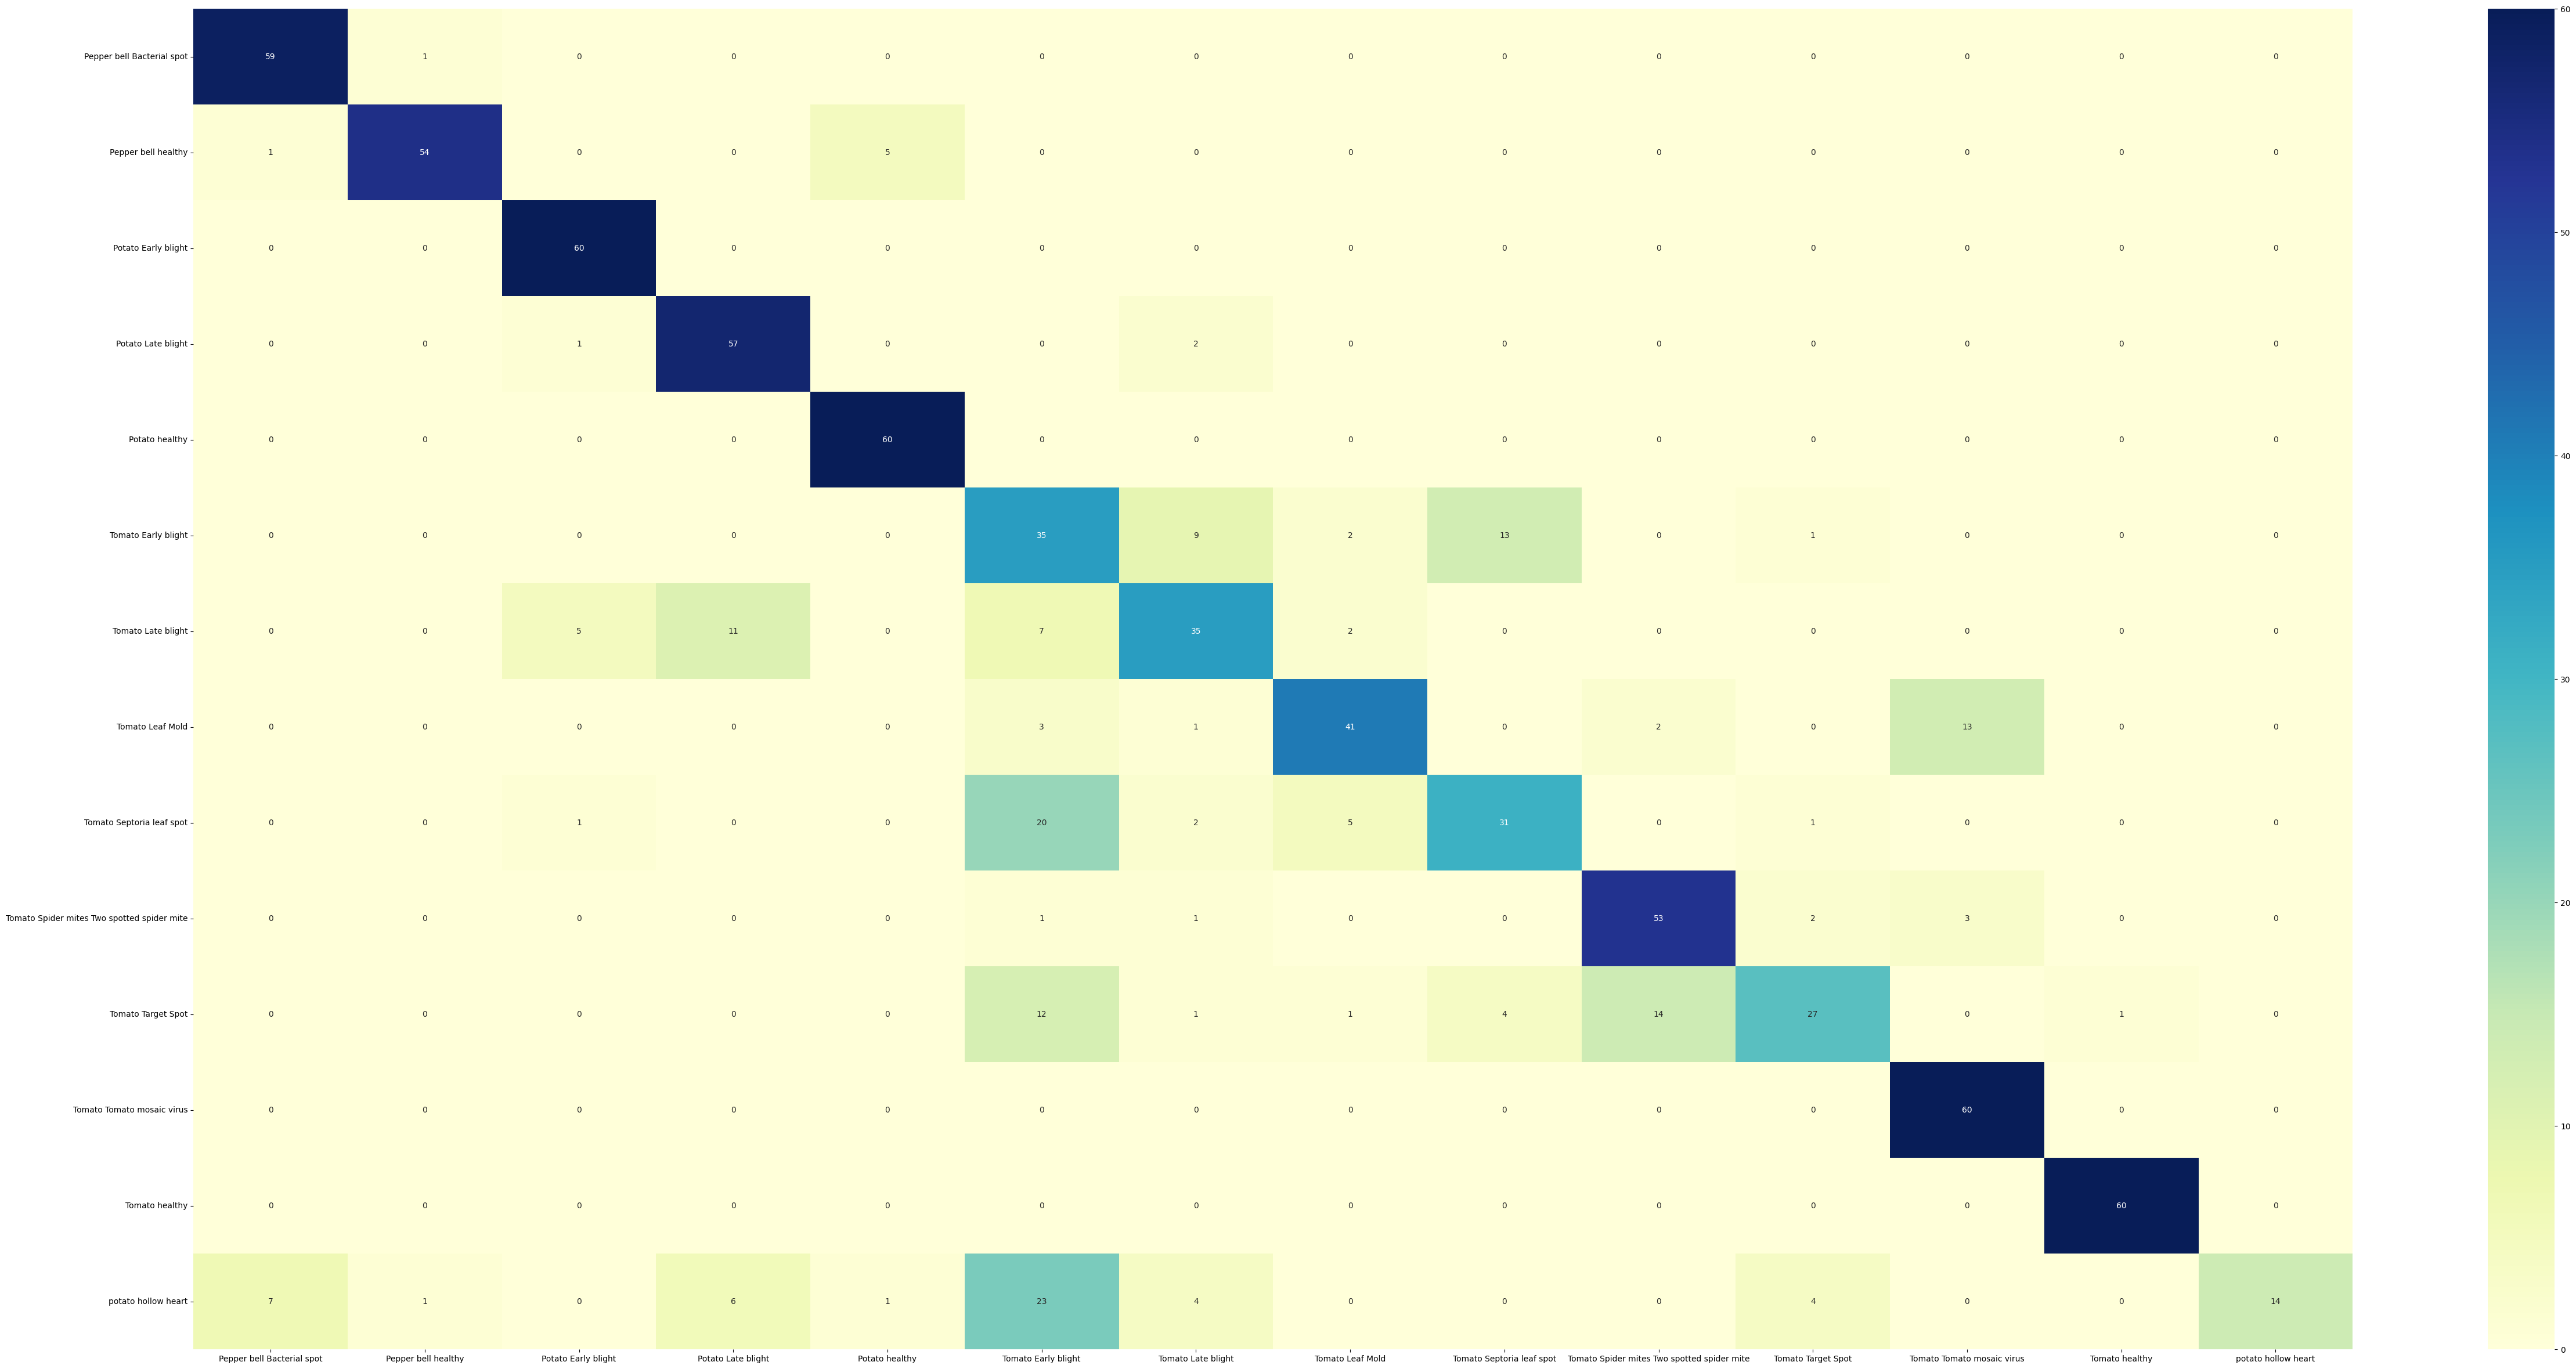

In [16]:
import seaborn as sn
df_cm = pd.DataFrame(cm, index = list(embedding_keys_2_labels.keys()),
                  columns = list(embedding_keys_2_labels.keys()))
plt.figure(figsize=(60,30))
sn.heatmap(df_cm, annot=True, cmap='YlGnBu')